# Handwritten recognition by CNN & Bidirectional LSTM
<br>
<br>

<center>

![image.png](https://nanonets.com/blog/content/images/2020/08/Hero-Gif-1.gif
)
</center>

## Problem Statement


A medical company needs to take handwritten prescription and retrieve the text from it. To do
this manually, it will require a lot of time and lots of cost to the company. So, the company
wants to automate this task. I need to create a neural network model that will take images
as input, read the text images, and convert it into digital text.
To solve this problem, we will create a CNN LSTM model.

## Dataset description

The [IAM Handwriting dataset](https://fki.tic.heia-fr.ch/databases/download-the-iam-handwriting-database) contains forms of handwritten English text which can be used to train and test handwritten text recognizers and to perform writer identification and verification experiments.
<br>
The dataset contains forms of unconstrained handwritten text, which were scanned at a resolution of 300dpi and saved as PNG images with 256 gray levels. The figure below provides samples of a complete form, a text line and some extracted words.
<br>
The dataset contains over 8000
images and their digital text.
This is a sample from text file,
a01-000u-01-03 ok 156 1400 937 294 59 NN Labour <br>
where,<br>
a01-000u-01-03: image location+ image id
Labour: actual word<br>
Image file contains one word in each image




## Import the libraries 

In [ ]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os

np.random.seed(42)
tf.random.set_seed(42)

## Data collection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tarfile
# open file
file = tarfile.open('/content/drive/MyDrive/words.tgz')
# extracting file
file.extractall('./words')
file.close()


In [ ]:
! ls '/content/words'

a01  a06  b05  c04  d05  e04  f03  g03	h01  h07  k01  l01  m02  n02  p02  r06
a02  b01  b06  c06  d06  e06  f04  g04	h02  j01  k02  l03  m03  n03  p03
a03  b02  c01  d01  d07  e07  f07  g05	h04  j04  k03  l04  m04  n04  p06
a04  b03  c02  d03  e01  f01  g01  g06	h05  j06  k04  l07  m06  n06  r02
a05  b04  c03  d04  e02  f02  g02  g07	h06  j07  k07  m01  n01  p01  r03


## Read the first 10000 from dataset

In [ ]:
with open('/content/parser.txt') as f :
  contents = f.readlines()

lines = [line.strip() for line in contents ]
lines=lines[:10000]
lines[:10]

['a01-000u-00-00 ok 154 408 768 27 51 AT A',
 'a01-000u-00-01 ok 154 507 766 213 48 NN MOVE',
 'a01-000u-00-02 ok 154 796 764 70 50 TO to',
 'a01-000u-00-03 ok 154 919 757 166 78 VB stop',
 'a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.',
 'a01-000u-00-05 ok 154 1438 746 382 73 NP Gaitskell',
 'a01-000u-00-06 ok 154 1896 757 173 72 IN from',
 'a01-000u-01-00 ok 156 395 932 441 100 VBG nominating',
 'a01-000u-01-01 ok 156 901 958 147 79 DTI any',
 'a01-000u-01-02 ok 156 1112 958 208 42 AP more']

## split the data to training , validation and testing samples

In [ ]:
words_list = []
for line in lines:
    if line[0] == "#":
        continue
    if line.split(" ")[1] != "err":  # We don't need to deal with errored entries.
        words_list.append(line)

len(words_list)

np.random.shuffle(words_list)

In [ ]:
split_idx = int(0.9 * len(words_list)) # to take 90% from  data to training 
train_samples = words_list[:split_idx]
test_samples = words_list[split_idx:]

val_split_idx = int(0.5 * len(test_samples)) # to take 5% from data to validation and test  
validation_samples = test_samples[:val_split_idx]
test_samples = test_samples[val_split_idx:]

assert len(words_list) == len(train_samples) + len(validation_samples) + len(
    test_samples
)

print(f"Total training samples: {len(train_samples)}")
print(f"Total validation samples: {len(validation_samples)}")
print(f"Total test samples: {len(test_samples)}")

Total training samples: 7853
Total validation samples: 436
Total test samples: 437


## Data input pipeline

We start building our data input pipeline by first preparing the image paths.

In [ ]:
base_image_path = os.path.join("words")

def get_image_paths_and_labels(samples):
    paths = []
    corrected_samples = []
    for (i, file_line) in enumerate(samples):
        line_split = file_line.strip()
        line_split = line_split.split(" ")

        # Each line split will have this format for the corresponding image:
        # part1/part1-part2/part1-part2-part3.png
        image_name = line_split[0]
        partI = image_name.split("-")[0]
        partII = image_name.split("-")[1]
        img_path = os.path.join(
            base_image_path, partI, partI + "-" + partII, image_name + ".png"
        )
        if os.path.getsize(img_path):
            paths.append(img_path)
            corrected_samples.append(file_line.split("\n")[0])

    return paths, corrected_samples


train_img_paths, train_labels = get_image_paths_and_labels(train_samples)
validation_img_paths, validation_labels = get_image_paths_and_labels(validation_samples)
test_img_paths, test_labels = get_image_paths_and_labels(test_samples)

In [ ]:
# Find maximum length and the size of the vocabulary in the training data.
train_labels_cleaned = []
characters = set()
max_len = 0

for label in train_labels:
    label = label.split(" ")[-1].strip() #to remove all white space characters—spaces, tabs, new lines
    for char in label:
        characters.add(char)

    max_len = max(max_len, len(label))
    train_labels_cleaned.append(label)

print("Maximum length: ", max_len)
print("Vocab size: ", len(characters))

# Check some label samples.
train_labels_cleaned[:10]

Maximum length:  16
Vocab size:  74


['been',
 'Minister',
 'an',
 'service',
 'the',
 'are',
 'State',
 'Will',
 'the',
 'Brown']

In [ ]:
#do the same thing for valid and test data
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip() #to remove all white space characters—spaces, tabs, new lines
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)

### Building the character vocabulary


In [ ]:

AUTOTUNE = tf.data.AUTOTUNE

# Mapping characters to integers.
char_to_num = StringLookup(vocabulary=list(characters), mask_token=None)

# Mapping integers back to original characters.
num_to_char = StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

### Resizing images without distortion

Instead of square images, many OCR models work with rectangular images. This will become
clearer in a moment when we will visualize a few samples from the dataset. While
aspect-unaware resizing square images does not introduce a significant amount of
distortion this is not the case for rectangular images. But resizing images to a uniform
size is a requirement for mini-batching. So we need to perform our resizing such that
the following criteria are met:

* Aspect ratio is preserved.
* Content of the images is not affected.

In [ ]:
def distortion_free_resize(image, img_size):
    w, h = img_size
    image = tf.image.resize(image, size=(h, w), preserve_aspect_ratio=True)

    # Check tha amount of padding needed to be done.
    pad_height = h - tf.shape(image)[0]
    pad_width = w - tf.shape(image)[1]

    # Only necessary if you want to do same amount of padding on both sides.
    if pad_height % 2 != 0:
        height = pad_height // 2
        pad_height_top = height + 1
        pad_height_bottom = height
    else:
        pad_height_top = pad_height_bottom = pad_height // 2

    if pad_width % 2 != 0:
        width = pad_width // 2
        pad_width_left = width + 1
        pad_width_right = width
    else:
        pad_width_left = pad_width_right = pad_width // 2

    image = tf.pad(
        image,
        paddings=[
            [pad_height_top, pad_height_bottom],
            [pad_width_left, pad_width_right],
            [0, 0],
        ],
    )

    image = tf.transpose(image, perm=[1, 0, 2])
    image = tf.image.flip_left_right(image)
    return image


### Putting the utilities together

In [ ]:
batch_size = 64
padding_token = 99
image_width = 128
image_height = 32


def preprocess_image(image_path, img_size=(image_width, image_height)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0 #normalize the image
    return image


def vectorize_label(label):
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return label


def process_images_labels(image_path, label):
    image = preprocess_image(image_path)
    label = vectorize_label(label)
    return {"image": image, "label": label}


def prepare_dataset(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_images_labels, num_parallel_calls=AUTOTUNE
    )
    return dataset.batch(batch_size).cache().prefetch(AUTOTUNE)


## Prepare tf.data.Dataset objects


In [ ]:
train_ds = prepare_dataset(train_img_paths, train_labels_cleaned)
validation_ds = prepare_dataset(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_dataset(test_img_paths, test_labels_cleaned)

## Visualize a few samples

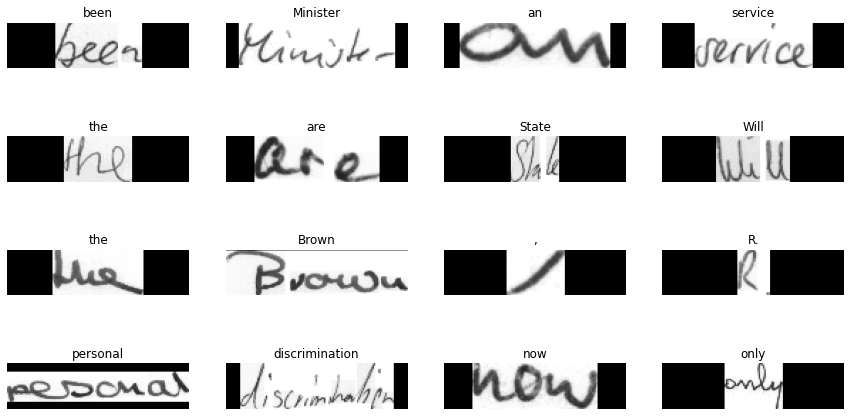

In [ ]:
for data in train_ds.take(1):
    images, labels = data["image"], data["label"]

    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    for i in range(16):
        img = images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        # Gather indices where label!= padding_token.
        label = labels[i]
        indices = tf.gather(label, tf.where(tf.math.not_equal(label, padding_token)))
        # Convert to string.
        label = tf.strings.reduce_join(num_to_char(indices))
        label = label.numpy().decode("utf-8")

        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")


plt.show()

## Building the Model


In [ ]:

class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions.
        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(name="label", shape=(None,))

    # First conv block.
    x = keras.layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block.
    x = keras.layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = keras.layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # filters in the last layer is 64. Reshape accordingly before
    # passing the output to the RNN part of the model.
    new_shape = ((image_width // 4), (image_height // 4) * 64)
    x = keras.layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = keras.layers.Dense(64, activation="relu", name="dense1")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNNs.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.25)
    )(x)
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(64, return_sequences=True, dropout=0.25)
    )(x)

    # +2 is to account for the two special tokens introduced by the CTC loss.
    x = keras.layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step.
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model.
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="handwriting_recognizer"
    )
    # Optimizer.
    opt = keras.optimizers.Adam()
    # Compile the model and return.
    model.compile(optimizer=opt)
    return model


# Get the model.
model = build_model()
model.summary()

Model: "handwriting_recognizer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 128, 32, 1)] 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 128, 32, 32)  320         image[0][0]                      
__________________________________________________________________________________________________
pool1 (MaxPooling2D)            (None, 64, 16, 32)   0           Conv1[0][0]                      
__________________________________________________________________________________________________
Conv2 (Conv2D)                  (None, 64, 16, 64)   18496       pool1[0][0]                      
_____________________________________________________________________________

## Evaluation metric

[Edit Distance](https://en.wikipedia.org/wiki/Edit_distance)
is the most widely used metric for evaluating OCR models. In this section, we will
implement it and use it as a callback to monitor our model.<br>


In [ ]:
#We first segregate the validation images and their labels for convenience.
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [ ]:
#Now, we create a callback to monitor the edit distances.

def calculate_edit_distance(labels, predictions):
    # Get a single batch and convert its labels to sparse tensors.
    saprse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)

    # Make predictions and convert them to sparse tensors.
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, input_length=input_len, greedy=True
    )[0][0][:, :max_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    # Compute individual edit distances and average them out.
    edit_distances = tf.edit_distance(
        sparse_predictions, saprse_labels, normalize=False
    )
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(calculate_edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.4f}"
        )


## Training


In [ ]:
epochs = 128 

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
edit_distance_callback = EditDistanceCallback(prediction_model)

# Train the model.
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[edit_distance_callback],
)


Epoch 1/128
123/123 [==============================] - 23s 130ms/step - loss: 20.4530 - val_loss: 15.7193
Mean edit distance for epoch 1: 16.0000
Epoch 2/128
123/123 [==============================] - 14s 116ms/step - loss: 15.4497 - val_loss: 14.9170
Mean edit distance for epoch 2: 16.0000
Epoch 3/128
123/123 [==============================] - 14s 116ms/step - loss: 14.9276 - val_loss: 14.5212
Mean edit distance for epoch 3: 16.0000
Epoch 4/128
123/123 [==============================] - 14s 116ms/step - loss: 14.6357 - val_loss: 14.2649
Mean edit distance for epoch 4: 16.0000
Epoch 5/128
123/123 [==============================] - 14s 117ms/step - loss: 14.3542 - val_loss: 13.9369
Mean edit distance for epoch 5: 15.9394
Epoch 6/128
123/123 [==============================] - 14s 116ms/step - loss: 14.0860 - val_loss: 13.6820
Mean edit distance for epoch 6: 15.8776
Epoch 7/128
123/123 [==============================] - 14s 118ms/step - loss: 13.7887 - val_loss: 13.3203
Mean edit distance

## Testing

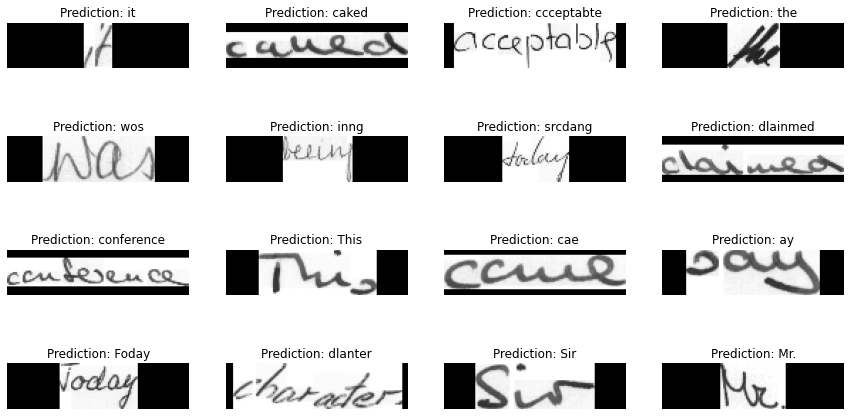

In [ ]:

# A utility function to decode the output of the network.
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text


#  Let's check results on some test samples.
for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [ ]:
model.save('handwriting_recognition.h5')

## For more information 

 **CTC loss:**
 - https://distill.pub/2017/ctc/
 - https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c

**handwriting recognition :**
- https://nanonets.com/blog/handwritten-character-recognition/